In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tqdm
import itertools
import pickle 
from pathlib import Path
import calendar

# Broker

In [2]:
class Broker:
    def __init__(self, price_df, capital, asset_ratio=0.5, fee=None):
        self.price_df = price_df.copy()
        self.capital = capital
        self.asset_ratio = asset_ratio
        self.fee = fee
        
        self.cash_ratio = 1 - self.asset_ratio

        self.portfolio_data = []
        
        # init
        init_index = self.price_df.index[0]
        self.asset_value = self.init_asset_value = self.capital * self.asset_ratio
        self.asset_amount = self.init_asset_amount = self.asset_value / self.price_df.loc[init_index, 'close']
        self.cash = self.init_cash = self.capital * self.cash_ratio
        
        # Initial portfolio historical data
        self.portfolio_data.append({
            'date': init_index,
            'nav': self.capital,
            'asset_value': self.asset_value,
            'asset_amount': self.asset_amount,
            'cash': self.cash
        })
    
    def asset_value_at(self, price=None):
        if price is None:
            return self.asset_value
        else:
            return self.asset_amount * price
    
    def nav_at(self, price=None):
        return self.asset_value_at(price) + self.cash
    
    def order(self, price, asset_amount, dt=None):
        # Calculate
        position_value = price * asset_amount
        
        if self.fee is not None:
            # Fee deduction
            if asset_amount > 0:
                posterior_cash = self.cash - position_value * (1 + self.fee / 100)
            else:
                posterior_cash = self.cash - position_value * (1 - self.fee / 100)
                
        posterior_asset_amount = self.asset_amount + asset_amount
        posterior_asset_value = posterior_asset_amount * price
        
        if posterior_cash < 0 or posterior_asset_value < 0:
            print('Fail to execute order', dt)
            return
        
        
        action = 'Buy' if asset_amount > 0 else 'Sell'
        last_asset_value = self.asset_value_at(price)
        last_asset_amount = self.asset_amount
        last_cash = self.cash
        last_nav = self.nav_at(price)
        
        # Update
        self.asset_amount = posterior_asset_amount
        self.asset_value = posterior_asset_value
        self.cash = posterior_cash
        
        self.portfolio_data.append({
            'date': dt,
            'price': price,
            'asset_value': last_asset_value,
            'asset_amount': last_asset_amount,
            'cash': last_cash,
            'nav': last_nav,

            'action': action,
            'position_value': position_value,

            'posterior_asset_value': self.asset_value_at(),
            'posterior_asset_amount': self.asset_amount,
            'posterior_cash': self.cash,
            'posterior_nav': self.nav_at(),
        })

    def buy(self, price, asset_amount, dt=None):
        if asset_amount < 0:
            raise NotImplementedError
        self.order(price, asset_amount, dt)
        
    def sell(self, price, asset_amount, dt=None):
        if asset_amount < 0:
            raise NotImplementedError
        self.order(price, -asset_amount, dt)
        
    def export_transaction(self):
        portfolio_df = pd.DataFrame(data=self.portfolio_data).set_index('date')
        return portfolio_df
    
    def export_price(self):
        portfolio_df = self.export_transaction()
        
        # Merge to price_df
        portfolio_price_df = self.price_df.merge(portfolio_df, how='left', left_index=True, right_index=True)
        portfolio_price_df[['asset_amount', 'cash']] = portfolio_price_df[['posterior_asset_amount', 'posterior_cash']].ffill()
        portfolio_price_df.loc[portfolio_price_df.index.min(), ['asset_amount', 'cash']] = (self.init_asset_amount, self.init_cash) 
        portfolio_price_df[['asset_amount', 'cash']] = portfolio_price_df[['asset_amount', 'cash']].ffill()
        portfolio_price_df['asset_value'] = portfolio_price_df['asset_amount'] * price_df['close']
        portfolio_price_df['nav'] = portfolio_price_df['asset_value'] + portfolio_price_df['cash']
        portfolio_price_df['price'] = price_df['close']
        portfolio_price_df = portfolio_price_df.groupby('date').last()
        portfolio_price_df.drop(columns=['action', 'position_value', 'posterior_asset_value',
               'posterior_asset_amount', 'posterior_cash', 'posterior_nav'], inplace=True)
        
        return portfolio_price_df

In [3]:
def buy_and_hold_by_ratio(price_df, asset_ratio, capital):
    cash_ratio = 1 - asset_ratio
    
    buy_and_hold_df = price_df.copy()
    
    price = buy_and_hold_df['close'].iloc[0]
    buy_and_hold_df['asset_amount'] = asset_ratio * capital / price
    buy_and_hold_df['asset_value'] = buy_and_hold_df['asset_amount'] * buy_and_hold_df['close']
    buy_and_hold_df['cash'] = cash_ratio * capital
    buy_and_hold_df['nav'] = buy_and_hold_df['asset_value'] + buy_and_hold_df['cash']
    return buy_and_hold_df

# Half month trigger

In [4]:
def semi_deviation(x):
    return x[x < 0].std()
def half_month_grouper(dt):
    if dt.day <= 15:
        return pd.Timestamp(dt.year, dt.month, 15, 13, 0, 0)
    else:
        last_day = calendar.monthrange(dt.year, dt.month)[1]
        return pd.Timestamp(dt.year, dt.month, last_day, 13, 0, 0)
def calculate_half_month_std(price_df):
    daily_prices = price_df.resample('1d').last()['close']
    daily_price_df = pd.DataFrame(data=dict(price=daily_prices), index=daily_prices.index)

    daily_price_df['period'] = daily_price_df.index.map(half_month_grouper)
    daily_price_df['return'] = daily_price_df['price'].pct_change()
    # periodically_return_stds = daily_price_df.groupby('period')['return'].apply(np.std)
    periodically_return_stds = daily_price_df.groupby('period')['return'].apply(semi_deviation)
    return periodically_return_stds

# Initial capital & fee

In [5]:
CAPITAL = 1000
FEE = 0.0

In [6]:
START_DATE = '2020-01-01'
END_DATE = '2021-12-31'

# BTC

In [7]:

price_df = pd.read_csv('dataset/BTCUSDT-1min.csv',
                 index_col='date',
                 parse_dates=['date'])
price_df = price_df[['open', 'high', 'low', 'close']]
price_df.index = price_df.index.map(lambda ts: pd.Timestamp(ts.year, ts.month, ts.day, ts.hour, ts.minute, 0))
price_df.sort_index(inplace=True)
price_df = price_df.loc[START_DATE: END_DATE]
price_df

,open,high,low,close
date,,,,
2020-01-01 00:00:00,7195.24,7196.25,7183.14,7186.68
2020-01-01 00:01:00,7187.67,7188.06,7182.20,7184.03
2020-01-01 00:02:00,7184.41,7184.71,7180.26,7182.43
2020-01-01 00:03:00,7183.83,7188.94,7182.49,7185.94
2020-01-01 00:04:00,7185.54,7185.54,7178.64,7179.78
...,...,...,...,...
2021-12-31 23:55:00,46283.00,46287.00,46247.00,46247.00
2021-12-31 23:56:00,46247.00,46274.00,46241.00,46246.00
2021-12-31 23:57:00,46246.00,46272.00,46239.00,46240.00


In [8]:
price_df

,open,high,low,close
date,,,,
2020-01-01 00:00:00,7195.24,7196.25,7183.14,7186.68
2020-01-01 00:01:00,7187.67,7188.06,7182.20,7184.03
2020-01-01 00:02:00,7184.41,7184.71,7180.26,7182.43
2020-01-01 00:03:00,7183.83,7188.94,7182.49,7185.94
2020-01-01 00:04:00,7185.54,7185.54,7178.64,7179.78
...,...,...,...,...
2021-12-31 23:55:00,46283.00,46287.00,46247.00,46247.00
2021-12-31 23:56:00,46247.00,46274.00,46241.00,46246.00
2021-12-31 23:57:00,46246.00,46272.00,46239.00,46240.00


In [9]:

buy_and_hold_price_df = buy_and_hold_by_ratio(price_df, asset_ratio=1.0, capital=CAPITAL).resample('1d').last()
buy_and_hold_price_df

,open,high,low,close,asset_amount,asset_value,cash,nav
date,,,,,,,,
2020-01-01,7198.71,7201.74,7198.00,7200.85,0.139146,1001.971703,0.0,1001.971703
2020-01-02,6962.59,6965.74,6961.24,6965.71,0.139146,969.252840,0.0,969.252840
2020-01-03,7315.18,7345.00,7315.18,7344.96,0.139146,1022.024078,0.0,1022.024078
2020-01-04,7355.00,7355.55,7351.26,7354.11,0.139146,1023.297267,0.0,1023.297267
2020-01-05,7359.26,7362.37,7357.17,7358.75,0.139146,1023.942905,0.0,1023.942905
...,...,...,...,...,...,...,...,...
2021-12-27,50678.00,50711.00,50654.00,50703.00,0.139146,7055.135334,0.0,7055.135334
2021-12-28,47564.00,47565.00,47517.00,47546.00,0.139146,6615.850434,0.0,6615.850434
2021-12-29,46413.00,46476.00,46413.00,46466.00,0.139146,6465.572420,0.0,6465.572420


count    48.000000
mean      0.022909
std       0.019289
min       0.004010
25%       0.012647
50%       0.017869
75%       0.028757
max       0.132411
Name: return, dtype: float64

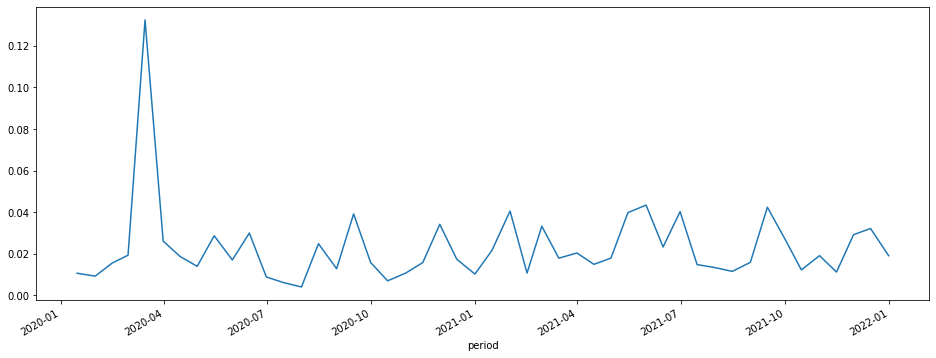

In [10]:
broker = Broker(price_df, capital=CAPITAL, asset_ratio=1.0, fee=FEE)
periodically_return_stds = calculate_half_month_std(price_df)
periodically_return_stds.plot(figsize=(16, 6))
periodically_return_stds.describe()

## Take action

In [11]:
is_reduce_voltality_phrase = False
for period, std in periodically_return_stds.items():
        
    if period > price_df.index.max():
        break
        
    price = price_df.loc[period, 'close']
    
    if std >= 0.08:
        print(period, std, 'sell 20%', )
        # Sell 20% of current asset amount
        sell_asset_ratio = 0.20
        broker.sell(price,
                    asset_amount=broker.asset_amount*sell_asset_ratio,
                    dt=period)
        is_reduce_voltality_phrase = True
    elif std >= 0.06:
        print(period, std, 'sell 10%', )
        # Sell 10% of current asset amount
        sell_asset_ratio = 0.10
        broker.sell(price,
            asset_amount=broker.asset_amount*sell_asset_ratio,
            dt=period)
        is_reduce_voltality_phrase = True
    else:
        if is_reduce_voltality_phrase:
            print(period, std, 'buy back', broker.cash/price)
            is_reduce_voltality_phrase = False
            
            # Buy back with all of current cash
            broker.buy(price,
                asset_amount=int(broker.cash)/price,
                dt=period)
    
        

2020-03-15 13:00:00 0.13241136828590452 sell 20%
2020-03-31 13:00:00 0.026061463530755166 buy back 0.022952399762936206


In [12]:
portfolio_df = broker.export_transaction()
portfolio_price_df = broker.export_price().resample('1d').last()

In [13]:
portfolio_df

,nav,asset_value,asset_amount,cash,price,action,position_value,posterior_asset_value,posterior_asset_amount,posterior_cash,posterior_nav
date,,,,,,,,,,,
2020-01-01 00:00:00,1000.000000,1000.000000,0.139146,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-15 13:00:00,739.178592,739.178592,0.139146,0.000000,5312.24,Sell,-147.835718,591.342873,0.111317,147.835718,739.178592
2020-03-31 13:00:00,864.825483,716.989764,0.111317,147.835718,6440.97,Buy,147.000000,863.989764,0.134140,0.835718,864.825483


## NAV

In [14]:
nav_df = pd.DataFrame()
nav_df['buy and hold'] = buy_and_hold_price_df['nav']
nav_df['large cap'] = portfolio_price_df['nav']
nav_df['return'] = nav_df['large cap'].pct_change()
sharpe_ratio = nav_df['return'].mean() / nav_df['return'].std()
print('Sharpe ratio', sharpe_ratio)

Sharpe ratio 0.08262736375872161


<AxesSubplot:title={'center':'NAV'}, xlabel='date'>

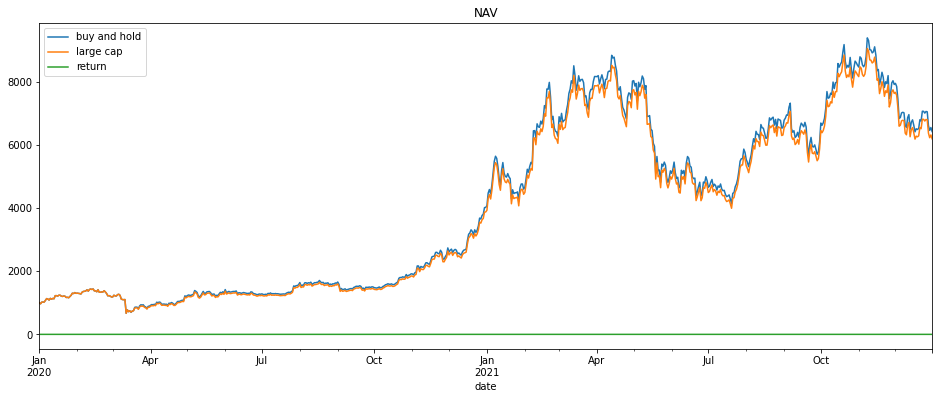

In [15]:
nav_df.plot(title='NAV', figsize=(16, 6))

## Drawdown

<AxesSubplot:title={'center':'Drawdown'}, xlabel='date'>

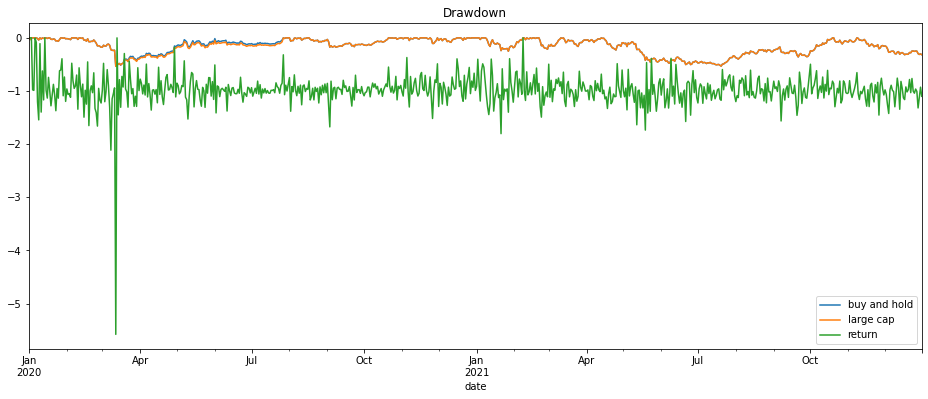

In [16]:
def drawdown(prices):
    cummax = prices.cummax()
    drawdown = (prices - cummax) / cummax
    return drawdown
drawdown_df = nav_df.apply(drawdown)

drawdown_df.plot(title='Drawdown', figsize=(16, 6))

## Asset value VS Cash

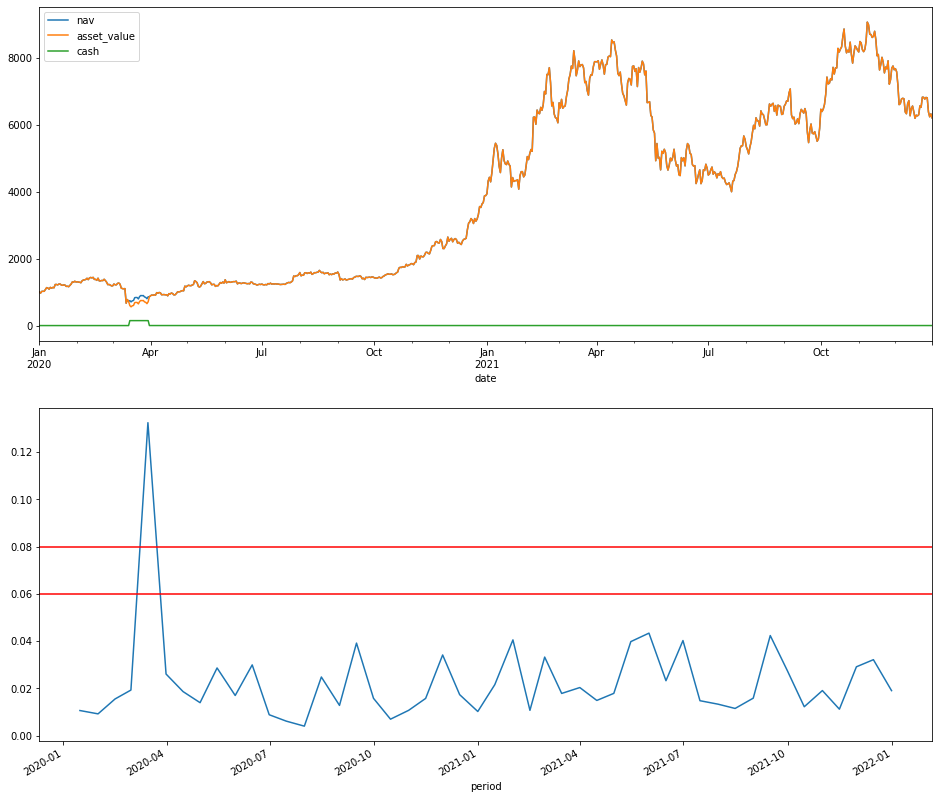

In [17]:
fig, axes = plt.subplots(2, figsize=(16, 15))
portfolio_price_df.plot(y=['nav', 'asset_value', 'cash'], ax=axes[0])
periodically_return_stds.plot(ax=axes[1])

axes[1].axhline(y=0.08, color='r', linestyle='-')
axes[1].axhline(y=0.06, color='r', linestyle='-')

## Export result

In [18]:
nav_df.to_excel('Large_Cap_BTC_NAV.xlsx')
drawdown_df.to_excel('Large_Cap_BTC_Drawdown.xlsx')

# ETH

In [19]:

price_df = pd.read_csv('dataset/ETHUSDT-1min.csv',
                 index_col='date',
                 parse_dates=['date'])
price_df = price_df[['open', 'high', 'low', 'close']]
price_df.index = price_df.index.map(lambda ts: pd.Timestamp(ts.year, ts.month, ts.day, ts.hour, ts.minute, 0))
price_df.sort_index(inplace=True)

price_df = price_df.loc[START_DATE: END_DATE]
price_df

,open,high,low,close
date,,,,
2020-01-01 00:00:00,129.16,129.19,128.96,129.02
2020-01-01 00:01:00,128.99,129.11,128.99,129.02
2020-01-01 00:02:00,129.00,129.05,128.94,128.98
2020-01-01 00:03:00,128.95,129.02,128.94,128.98
2020-01-01 00:04:00,128.97,128.97,128.80,128.88
...,...,...,...,...
2021-12-31 23:55:00,3679.50,3679.70,3676.80,3677.00
2021-12-31 23:56:00,3677.00,3678.70,3676.80,3677.30
2021-12-31 23:57:00,3677.30,3679.30,3677.30,3677.80


In [20]:
price_df

,open,high,low,close
date,,,,
2020-01-01 00:00:00,129.16,129.19,128.96,129.02
2020-01-01 00:01:00,128.99,129.11,128.99,129.02
2020-01-01 00:02:00,129.00,129.05,128.94,128.98
2020-01-01 00:03:00,128.95,129.02,128.94,128.98
2020-01-01 00:04:00,128.97,128.97,128.80,128.88
...,...,...,...,...
2021-12-31 23:55:00,3679.50,3679.70,3676.80,3677.00
2021-12-31 23:56:00,3677.00,3678.70,3676.80,3677.30
2021-12-31 23:57:00,3677.30,3679.30,3677.30,3677.80


In [21]:

buy_and_hold_price_df = buy_and_hold_by_ratio(price_df, asset_ratio=1.0, capital=CAPITAL).resample('1d').last()
buy_and_hold_price_df

,open,high,low,close,asset_amount,asset_value,cash,nav
date,,,,,,,,
2020-01-01,130.64,130.77,130.64,130.77,7.750736,1013.563789,0.0,1013.563789
2020-01-02,127.14,127.19,127.09,127.19,7.750736,985.816153,0.0,985.816153
2020-01-03,133.85,134.40,133.85,134.35,7.750736,1041.311425,0.0,1041.311425
2020-01-04,134.17,134.20,134.16,134.20,7.750736,1040.148814,0.0,1040.148814
2020-01-05,135.40,135.45,135.37,135.37,7.750736,1049.217176,0.0,1049.217176
...,...,...,...,...,...,...,...,...
2021-12-27,4038.00,4038.00,4032.80,4037.20,7.750736,31291.272671,0.0,31291.272671
2021-12-28,3796.30,3796.90,3790.60,3792.80,7.750736,29396.992714,0.0,29396.992714
2021-12-29,3625.80,3629.90,3625.80,3629.50,7.750736,28131.297473,0.0,28131.297473


count    48.000000
mean      0.028834
std       0.024065
min       0.005911
25%       0.014667
50%       0.023543
75%       0.033894
max       0.154870
Name: return, dtype: float64

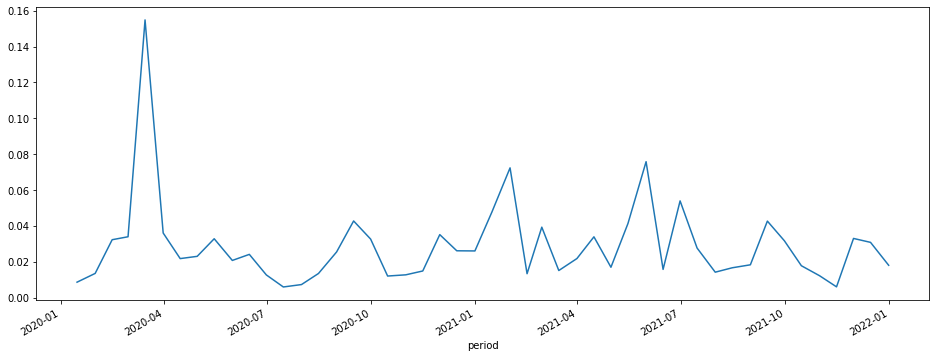

In [22]:
broker = Broker(price_df, capital=CAPITAL, asset_ratio=1.0, fee=FEE)
periodically_return_stds = calculate_half_month_std(price_df)
periodically_return_stds.plot(figsize=(16, 6))
periodically_return_stds.describe()

## Take action

In [23]:
is_reduce_voltality_phrase = False
for period, std in periodically_return_stds.items():
        
    if period > price_df.index.max():
        break
        
    price = price_df.loc[period, 'close']
    
    if std >= 0.14:
        print(period, std, 'sell 30%', )
        # Sell 30% of current asset amount
        sell_asset_ratio = 0.30
        broker.sell(price,
                    asset_amount=broker.asset_amount*sell_asset_ratio,
                    dt=period)
        is_reduce_voltality_phrase = True
    elif std >= 0.11:
        print(period, std, 'sell 20%', )
        # Sell 20% of current asset amount
        sell_asset_ratio = 0.20
        broker.sell(price,
            asset_amount=broker.asset_amount*sell_asset_ratio,
            dt=period)
        is_reduce_voltality_phrase = True
    elif std >= 0.09:
        print(period, std, 'sell 10%', )
        # Sell 10% of current asset amount
        sell_asset_ratio = 0.10
        broker.sell(price,
            asset_amount=broker.asset_amount*sell_asset_ratio,
            dt=period)
        is_reduce_voltality_phrase = True
    else:
        if is_reduce_voltality_phrase:
            print(period, std, 'buy back', broker.cash/price)
            is_reduce_voltality_phrase = False
            
            # Buy back with all of current cash
            broker.buy(price,
                asset_amount=int(broker.cash)/price,
                dt=period)
    
        

2020-03-15 13:00:00 0.15486971963094753 sell 30%
2020-03-31 13:00:00 0.03601113815419344 buy back 2.192295943692358


In [24]:
portfolio_df = broker.export_transaction()
portfolio_price_df = broker.export_price().resample('1d').last()

In [25]:
portfolio_df

,nav,asset_value,asset_amount,cash,price,action,position_value,posterior_asset_value,posterior_asset_amount,posterior_cash,posterior_nav
date,,,,,,,,,,,
2020-01-01 00:00:00,1000.000000,1000.000000,7.750736,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-15 13:00:00,967.679430,967.679430,7.750736,0.000000,124.85,Sell,-290.303829,677.375601,5.425515,290.303829,967.679430
2020-03-31 13:00:00,1008.750581,718.446752,5.425515,290.303829,132.42,Buy,290.000000,1008.446752,7.615517,0.303829,1008.750581


## NAV

In [26]:
nav_df = pd.DataFrame()
nav_df['buy and hold'] = buy_and_hold_price_df['nav']
nav_df['large cap'] = portfolio_price_df['nav']
nav_df['return'] = nav_df['large cap'].pct_change()
sharpe_ratio = nav_df['return'].mean() / nav_df['return'].std()
print('Sharpe ratio', sharpe_ratio)

Sharpe ratio 0.11250922929606878


<AxesSubplot:title={'center':'NAV'}, xlabel='date'>

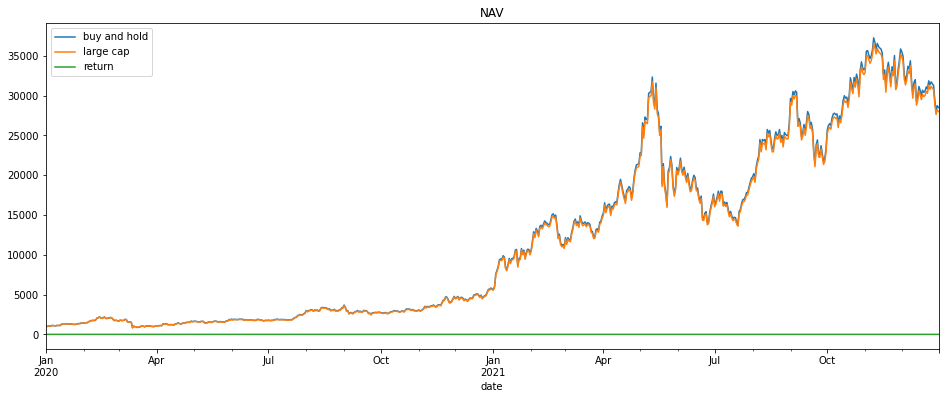

In [27]:
nav_df.plot(title='NAV', figsize=(16, 6))

## Drawdown

<AxesSubplot:title={'center':'Drawdown'}, xlabel='date'>

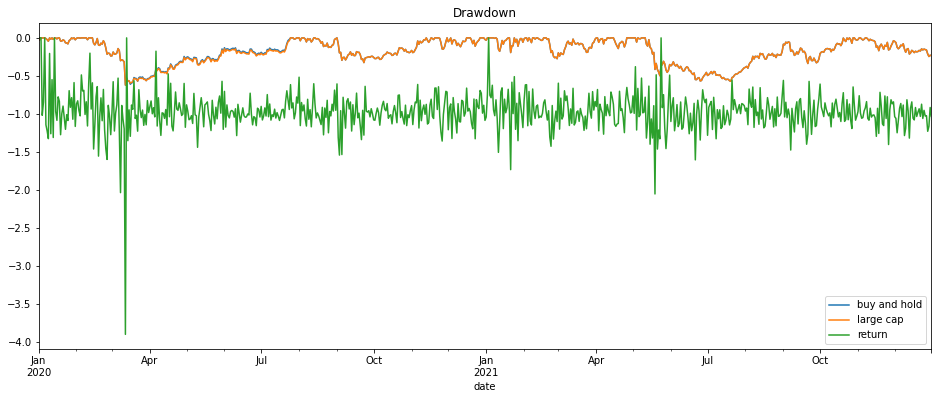

In [28]:
def drawdown(prices):
    cummax = prices.cummax()
    drawdown = (prices - cummax) / cummax
    return drawdown
drawdown_df = nav_df.apply(drawdown)

drawdown_df.plot(title='Drawdown', figsize=(16, 6))

## Asset value VS Cash

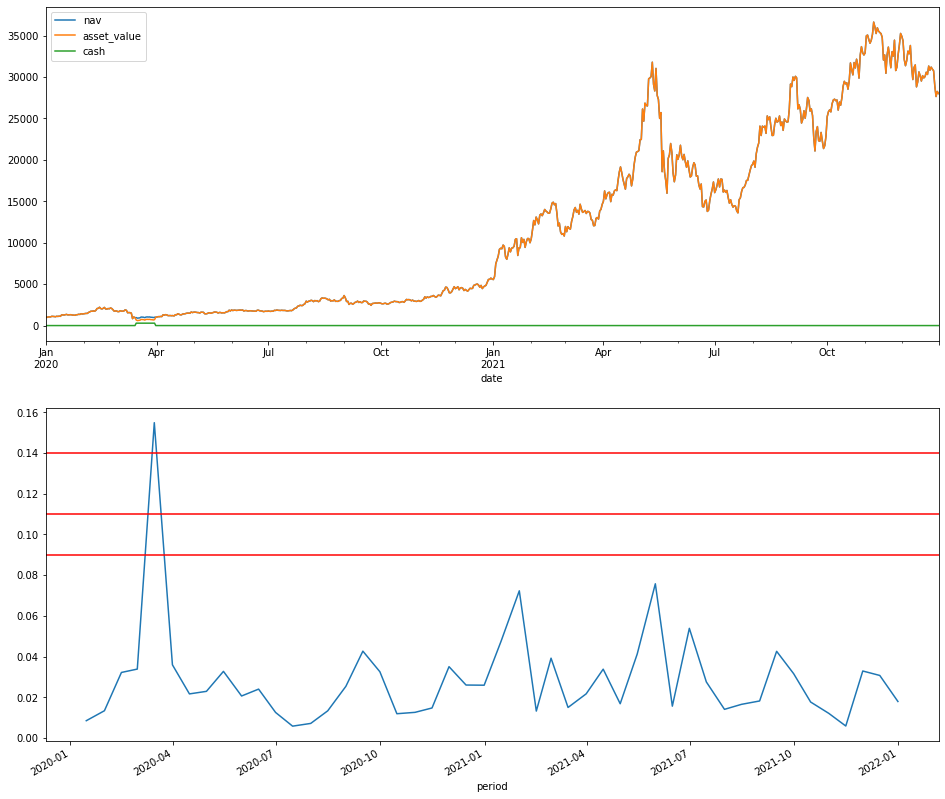

In [29]:
fig, axes = plt.subplots(2, figsize=(16, 15))
portfolio_price_df.plot(y=['nav', 'asset_value', 'cash'], ax=axes[0])


periodically_return_stds.plot(ax=axes[1])
axes[1].axhline(y=0.14, color='r', linestyle='-')
axes[1].axhline(y=0.11, color='r', linestyle='-')
axes[1].axhline(y=0.09, color='r', linestyle='-')

## Export result

In [30]:
nav_df.to_excel('Large_Cap_ETH_NAV.xlsx')
drawdown_df.to_excel('Large_Cap_ETH_Drawdown.xlsx')